In [1]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import pandas as pd

class ScratchKMeans:
    """
    K-means implementation from scratch
    
    Parameters
    ----------
    n_clusters : int
        Number of clusters
    n_init : int
        Number of times the algorithm will be run with different centroid seeds
    max_iter : int
        Maximum number of iterations for a single run
    tol : float
        Tolerance for centroid shift to declare convergence
    verbose : bool
        If True, prints progress during learning
    """
    def __init__(self, n_clusters, n_init=10, max_iter=300, tol=1e-4, verbose=False):
        # Store hyperparameters as attributes
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        
        # Variables to store results
        self.cluster_centers_ = None
        self.labels_ = None
        self.inertia_ = None
        self.n_iter_ = None
        
    def _init_centroids(self, X):
        """
        [Problem 1] Determine initial centroids
        Randomly select K data points
        """
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, self.n_clusters, replace=False)
        return X[indices]
    
    def _compute_sse(self, X, centroids, labels):
        """
        [Problem 2] Calculate SSE (Sum of Squared Errors)
        """
        sse = 0
        for k in range(self.n_clusters):
            cluster_points = X[labels == k]
            if len(cluster_points) > 0:
                # Calculate distance from all points in cluster to the centroid
                distances = np.sum((cluster_points - centroids[k]) ** 2, axis=1)
                sse += np.sum(distances)
        return sse
    
    def _assign_clusters(self, X, centroids):
        """
        [Problem 3] Assign each data point to the closest centroid
        """
        n_samples = X.shape[0]
        labels = np.zeros(n_samples, dtype=int)
        distances = np.zeros((n_samples, self.n_clusters))
        
        # Calculate distances from each point to all centroids
        for k in range(self.n_clusters):
            # Calculate Euclidean distance using numpy's norm function
            distances[:, k] = np.linalg.norm(X - centroids[k], axis=1)
        
        # Assign each point to the nearest centroid
        labels = np.argmin(distances, axis=1)
        
        return labels
    
    def _move_centroids(self, X, labels):
        """
        [Problem 4] Move centroids to the center of their assigned points
        """
        n_features = X.shape[1]
        centroids = np.zeros((self.n_clusters, n_features))
        
        for k in range(self.n_clusters):
            cluster_points = X[labels == k]
            if len(cluster_points) > 0:
                # Calculate mean of all points in the cluster
                centroids[k] = np.mean(cluster_points, axis=0)
            else:
                # If no points in cluster, keep the centroid as is
                if self.verbose:
                    print(f"Warning: Cluster {k} is empty")
        
        return centroids
    
    def _single_kmeans_run(self, X, init_centroids):
        """
        [Problem 5] Single run of K-means algorithm
        """
        centroids = init_centroids.copy()
        prev_centroids = None
        n_iter = 0
        
        while n_iter < self.max_iter:
            # Assign clusters
            labels = self._assign_clusters(X, centroids)
            
            # Move centroids
            new_centroids = self._move_centroids(X, labels)
            
            # Check for convergence
            if prev_centroids is not None:
                # Calculate the sum of differences between old and new centroids
                shift = np.sum(np.linalg.norm(new_centroids - prev_centroids, axis=1))
                if self.verbose:
                    print(f"Iteration {n_iter + 1}, centroid shift: {shift}")
                
                if shift < self.tol:
                    if self.verbose:
                        print(f"Converged after {n_iter + 1} iterations")
                    break
            
            prev_centroids = centroids.copy()
            centroids = new_centroids
            n_iter += 1
        
        # Calculate SSE for this run
        sse = self._compute_sse(X, centroids, labels)
        
        return centroids, labels, sse, n_iter + 1
    
    def fit(self, X):
        """
        [Problem 6] Run K-means clustering multiple times and select best result
        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Training data
        """
        best_sse = float('inf')
        best_centroids = None
        best_labels = None
        best_n_iter = 0
        
        for i in range(self.n_init):
            if self.verbose:
                print(f"\nRun {i + 1}/{self.n_init}")
            
            # Initialize centroids
            init_centroids = self._init_centroids(X)
            
            # Run K-means once
            centroids, labels, sse, n_iter = self._single_kmeans_run(X, init_centroids)
            
            # Keep track of the best result
            if sse < best_sse:
                best_sse = sse
                best_centroids = centroids
                best_labels = labels
                best_n_iter = n_iter
                if self.verbose:
                    print(f"New best SSE: {best_sse}")
        
        # Store the best result
        self.cluster_centers_ = best_centroids
        self.labels_ = best_labels
        self.inertia_ = best_sse
        self.n_iter_ = best_n_iter
        
        if self.verbose:
            print(f"\nFinal SSE: {self.inertia_}")
            print(f"Number of iterations: {self.n_iter_}")
        
        return self
    
    def predict(self, X):
        """
        [Problem 7] Predict cluster labels for new data
        """
        if self.cluster_centers_ is None:
            raise ValueError("Model not fitted yet. Call 'fit' first.")
        
        return self._assign_clusters(X, self.cluster_centers_)


In [2]:
def elbow_method(X, k_range, n_init=10, max_iter=300, tol=1e-4):
    """
    [Problem 8] Implementation of elbow method to find optimal k
    """
    sse_values = []
    
    for k in k_range:
        kmeans = ScratchKMeans(n_clusters=k, n_init=n_init, max_iter=max_iter, tol=tol)
        kmeans.fit(X)
        sse_values.append(kmeans.inertia_)
    
    # Plot the elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, sse_values, 'bo-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Sum of Squared Errors (SSE)')
    plt.title('Elbow Method for Optimal k')
    plt.grid(True)
    plt.show()
    
    return sse_values


In [3]:
def calculate_silhouette(X, labels, n_clusters):
    """
    [Problem 9] Calculate silhouette coefficients for all data points
    """
    n_samples = X.shape[0]
    silhouette_vals = np.zeros(n_samples)
    
    for i in range(n_samples):
        # Get the cluster of the current point
        cluster_i = labels[i]
        
        # Calculate a (cohesion) - average distance to other points in the same cluster
        points_in_cluster_i = X[labels == cluster_i]
        
        if len(points_in_cluster_i) > 1:  # More than one point in the cluster
            a_i = np.mean(np.linalg.norm(X[i] - points_in_cluster_i, axis=1))
        else:
            a_i = 0
        
        # Calculate b (separation) - find the nearest cluster and calculate average distance
        b_i = float('inf')
        
        for j in range(n_clusters):
            if j != cluster_i:
                points_in_cluster_j = X[labels == j]
                if len(points_in_cluster_j) > 0:
                    # Average distance to points in cluster j
                    avg_distance = np.mean(np.linalg.norm(X[i] - points_in_cluster_j, axis=1))
                    b_i = min(b_i, avg_distance)
        
        # Calculate silhouette coefficient
        if a_i == 0 and b_i == float('inf'):
            silhouette_vals[i] = 0
        elif a_i == 0:
            silhouette_vals[i] = 1
        elif b_i == float('inf'):
            silhouette_vals[i] = -1
        else:
            silhouette_vals[i] = (b_i - a_i) / max(a_i, b_i)
    
    return silhouette_vals


In [4]:
def plot_silhouette(X, k_range, n_init=10, max_iter=300, tol=1e-4):
    """
    Calculate and plot silhouette scores for different k values
    """
    silhouette_avgs = []
    
    for k in k_range:
        kmeans = ScratchKMeans(n_clusters=k, n_init=n_init, max_iter=max_iter, tol=tol)
        kmeans.fit(X)
        
        if k > 1:  # Silhouette score is only defined for k > 1
            silhouette_vals = calculate_silhouette(X, kmeans.labels_, k)
            silhouette_avg = np.mean(silhouette_vals)
            silhouette_avgs.append(silhouette_avg)
            
            # Plot silhouette plot
            plt.figure(figsize=(12, 8))
            y_ax_lower, y_ax_upper = 0, 0
            yticks = []
            
            for i in range(k):
                c_silhouette_vals = silhouette_vals[kmeans.labels_ == i]
                c_silhouette_vals.sort()
                y_ax_upper += len(c_silhouette_vals)
                color = cm.jet(i / k)
                plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, 
                         height=1.0, edgecolor='none', color=color)
                yticks.append((y_ax_lower + y_ax_upper) / 2)
                y_ax_lower += len(c_silhouette_vals)
            
            plt.axvline(silhouette_avg, color="red", linestyle="--")
            plt.yticks(yticks, range(1, k+1))
            plt.ylabel('Cluster')
            plt.xlabel('Silhouette coefficient')
            plt.title(f'Silhouette Plot for k={k}, Avg Silhouette Score: {silhouette_avg:.3f}')
            plt.show()
        else:
            silhouette_avgs.append(0)  # k=1 has no silhouette score
    
    # Plot average silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, silhouette_avgs, 'bo-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Average Silhouette Score')
    plt.title('Silhouette Analysis for Optimal k')
    plt.grid(True)
    plt.show()
    
    return silhouette_avgs

In [5]:
def generate_sample_data():
    X, _ = make_blobs(n_samples=100, n_features=2, centers=4, cluster_std=0.5, shuffle=True, random_state=0)
    return X

# Test the implementation
def test_kmeans():
    # Generate sample data
    X = generate_sample_data()
    
    # Create and fit the model
    kmeans = ScratchKMeans(n_clusters=4, n_init=10, max_iter=300, tol=1e-4, verbose=True)
    kmeans.fit(X)
    
    # Plot the results
    plt.figure(figsize=(10, 8))
    plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap='viridis', s=50, alpha=0.8)
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
                c='red', marker='x', s=200, linewidths=3)
    plt.title('K-means Clustering Results')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()
    
    # Elbow method
    elbow_method(X, range(1, 11))
    
    # Silhouette analysis
    plot_silhouette(X, range(2, 11))
    
    return kmeans

Testing K-means implementation with sample data...

Run 1/10
Iteration 2, centroid shift: 5.134432720341746
Iteration 3, centroid shift: 3.8969213783325056
Iteration 4, centroid shift: 1.6281630770005469
Iteration 5, centroid shift: 0.12643939245162833
Iteration 6, centroid shift: 0.0
Converged after 6 iterations
New best SSE: 48.63378320706403

Run 2/10
Iteration 2, centroid shift: 3.3731073962178972
Iteration 3, centroid shift: 1.0695693236272774
Iteration 4, centroid shift: 0.0
Converged after 4 iterations

Run 3/10
Iteration 2, centroid shift: 8.128326502303945
Iteration 3, centroid shift: 2.773780988850625
Iteration 4, centroid shift: 0.15154119935463345
Iteration 5, centroid shift: 0.0
Converged after 5 iterations

Run 4/10
Iteration 2, centroid shift: 8.80903182903864
Iteration 3, centroid shift: 4.296285424292641
Iteration 4, centroid shift: 0.6661579505099566
Iteration 5, centroid shift: 0.0
Converged after 5 iterations

Run 5/10
Iteration 2, centroid shift: 5.270237069607903


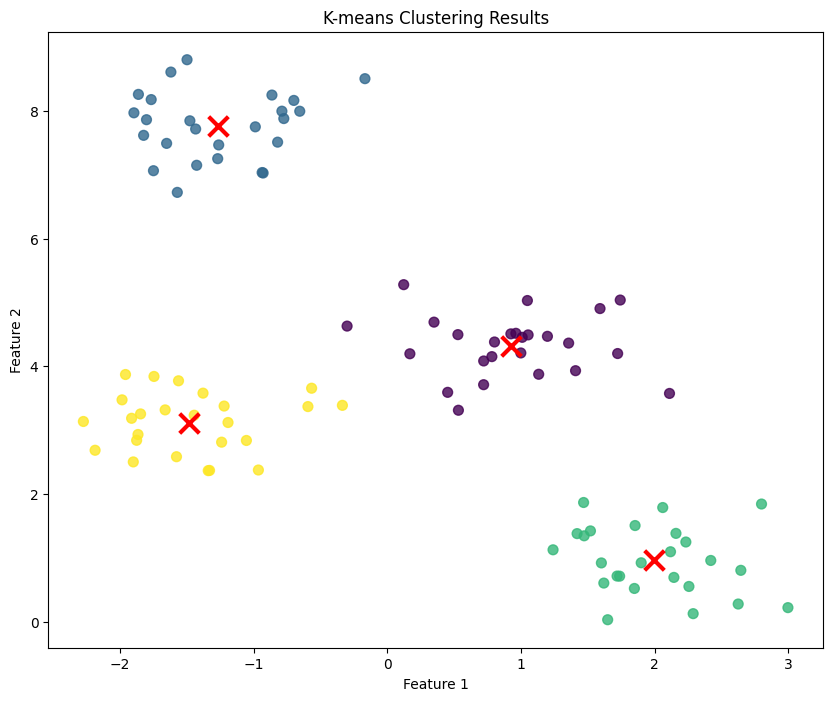

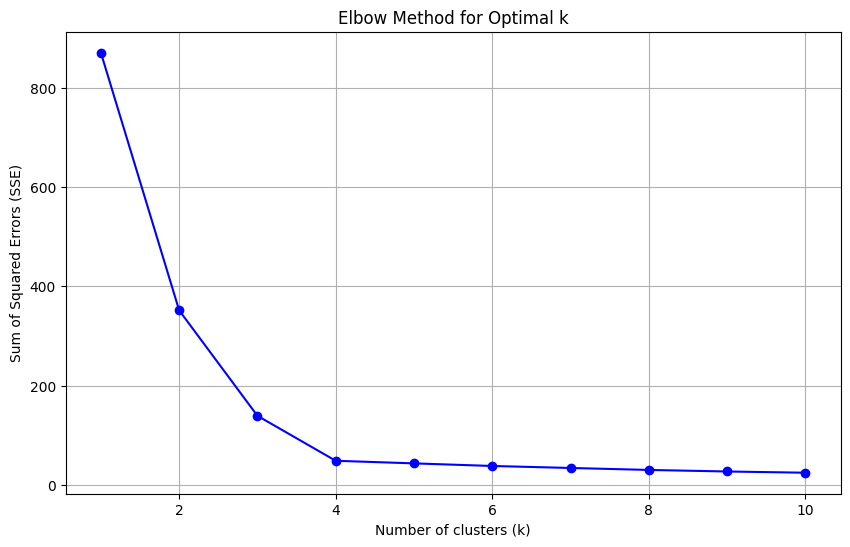

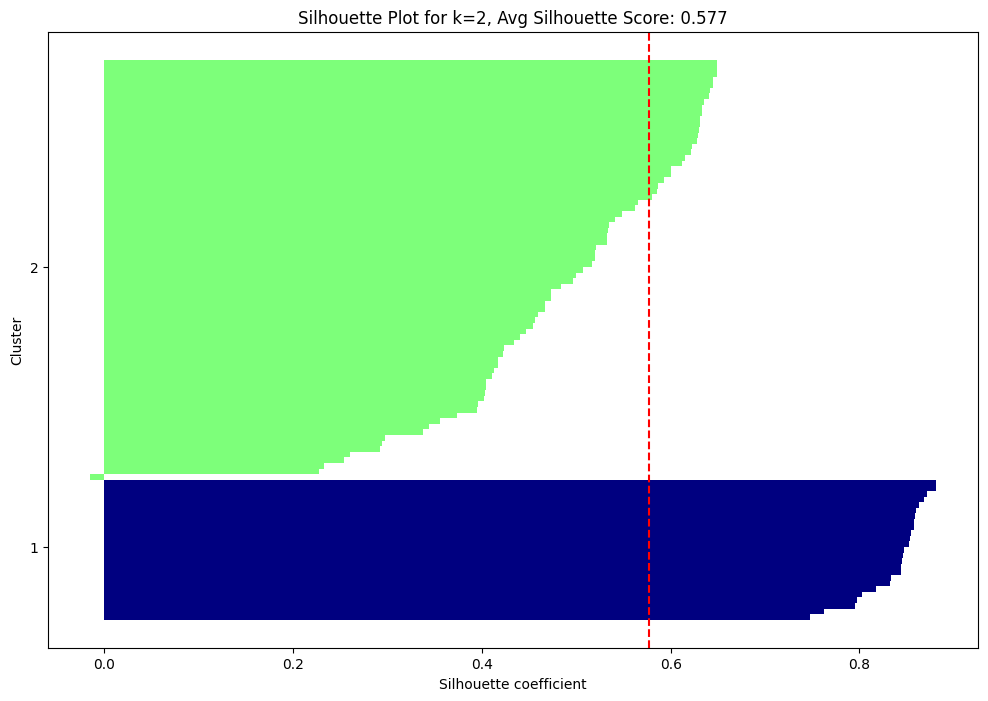

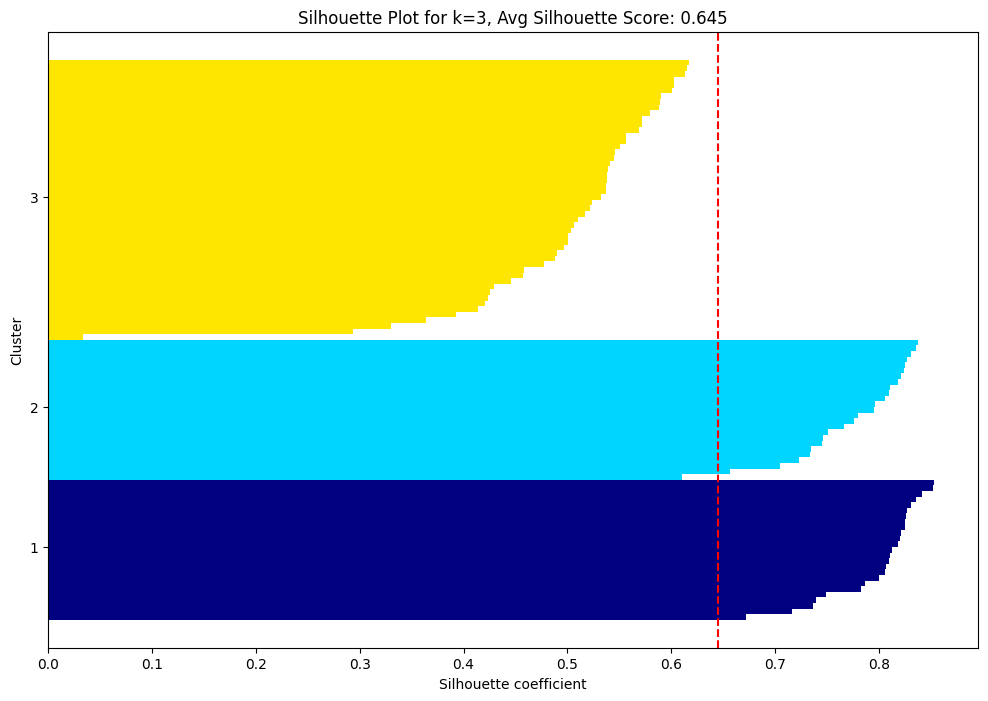

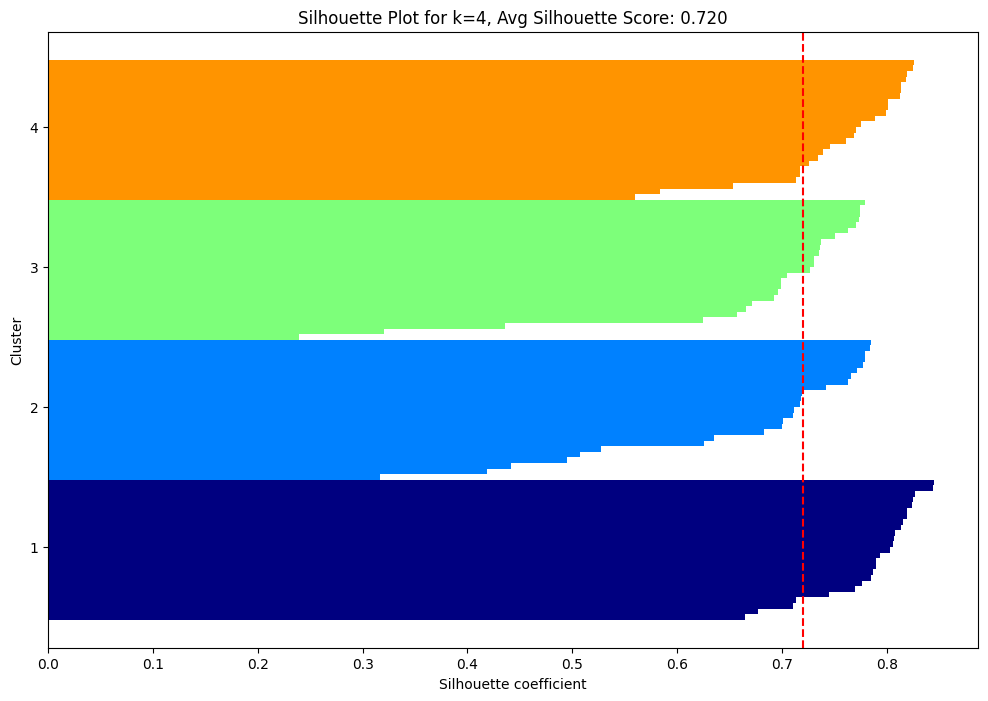

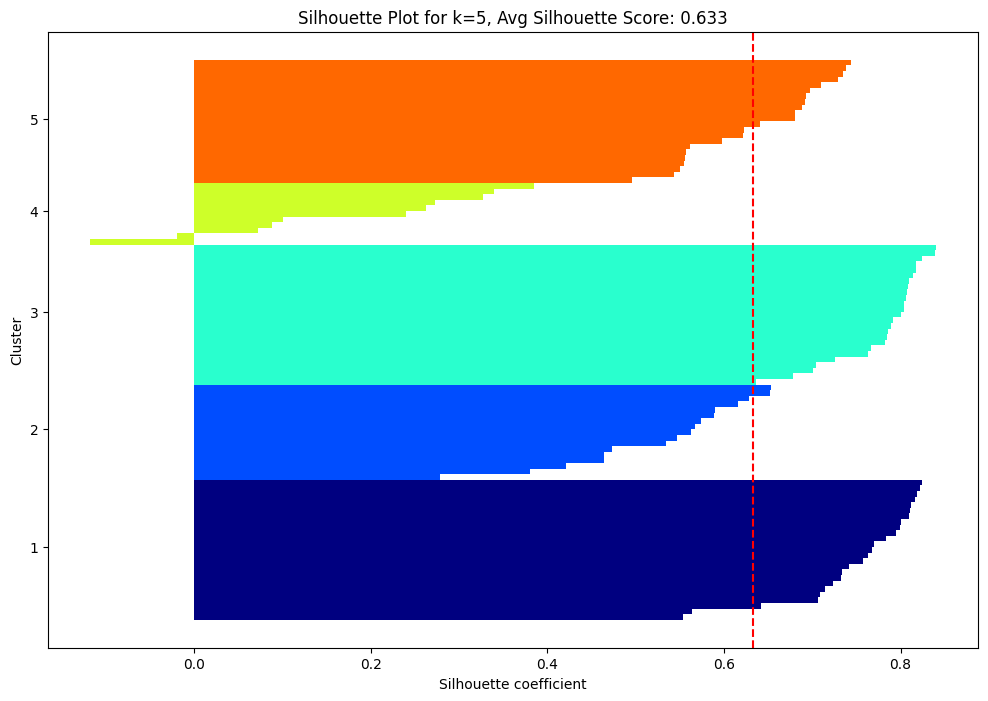

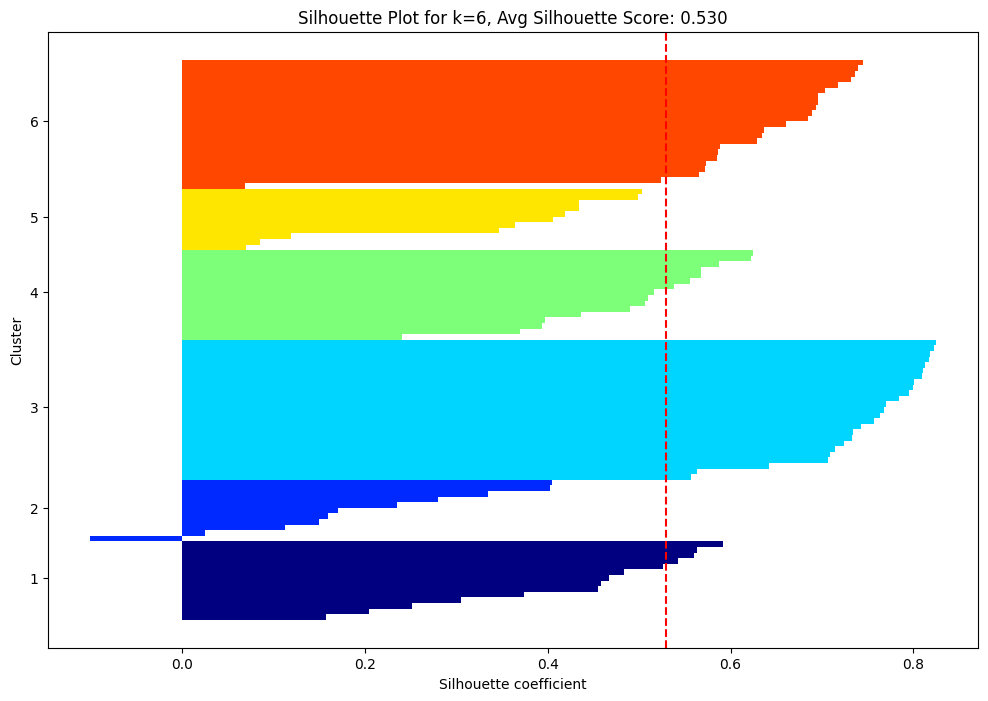

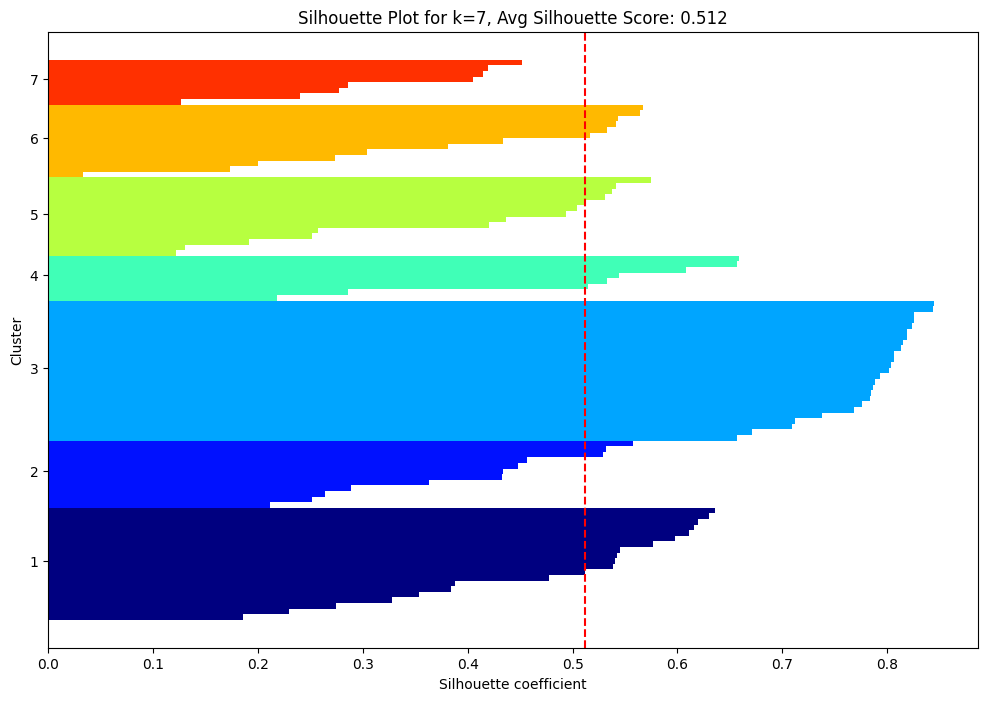

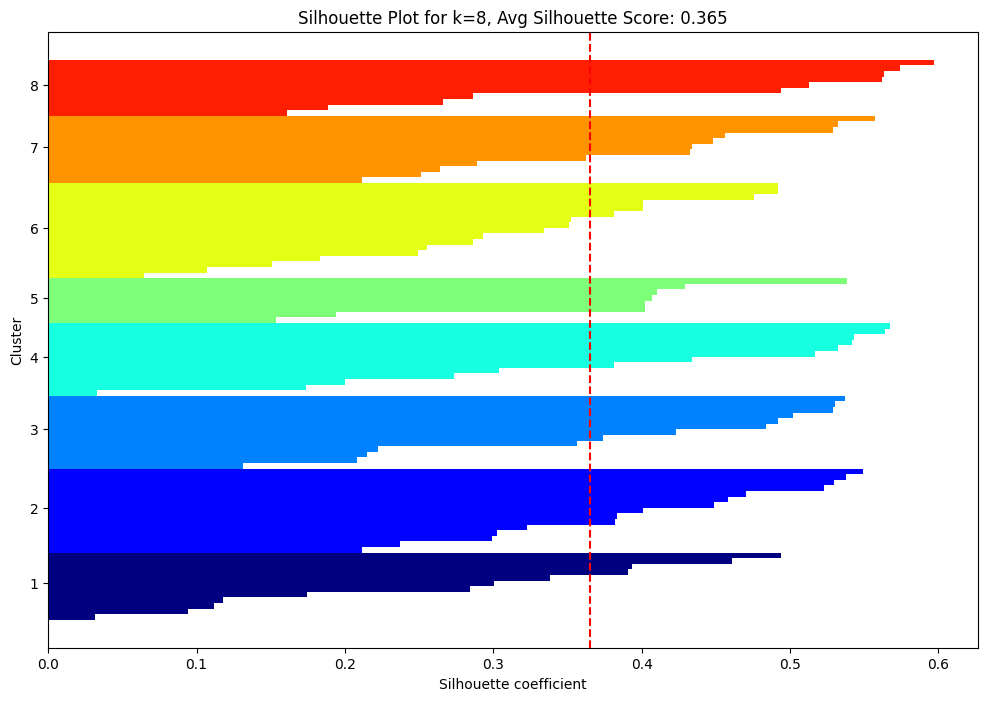

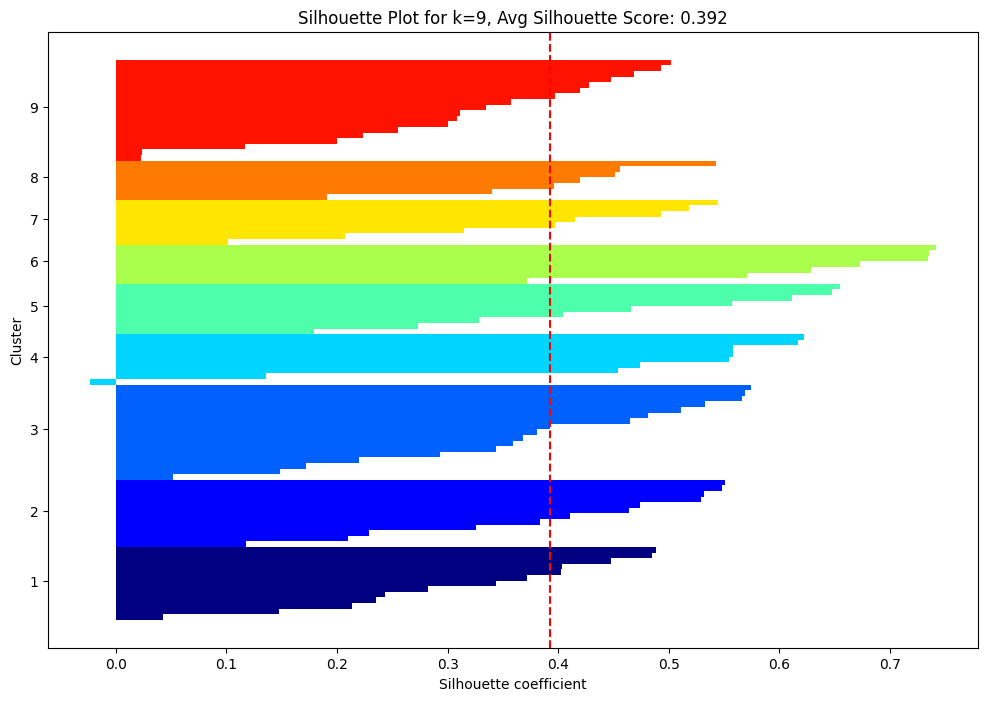

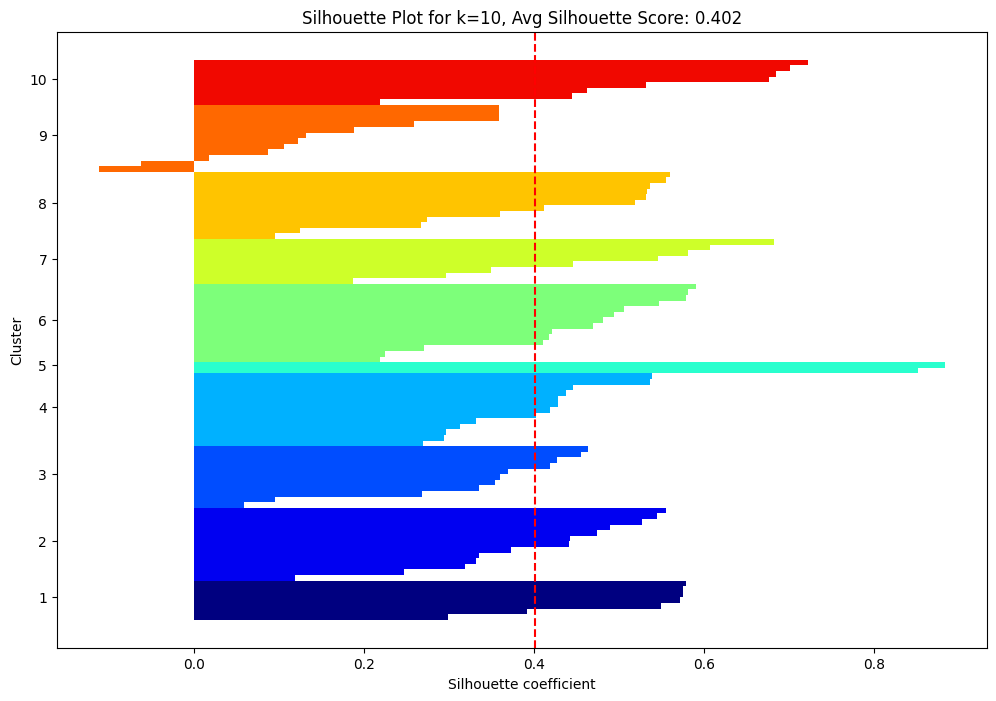

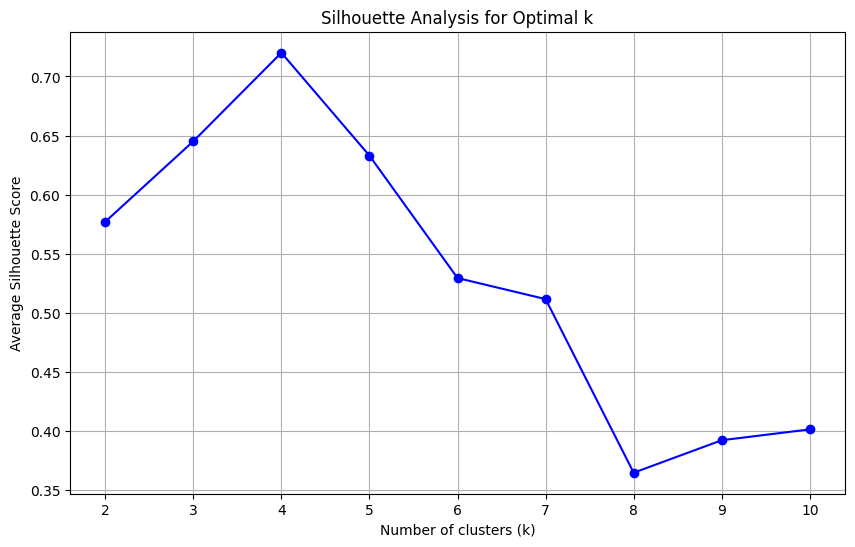


Analyzing wholesale customers data...


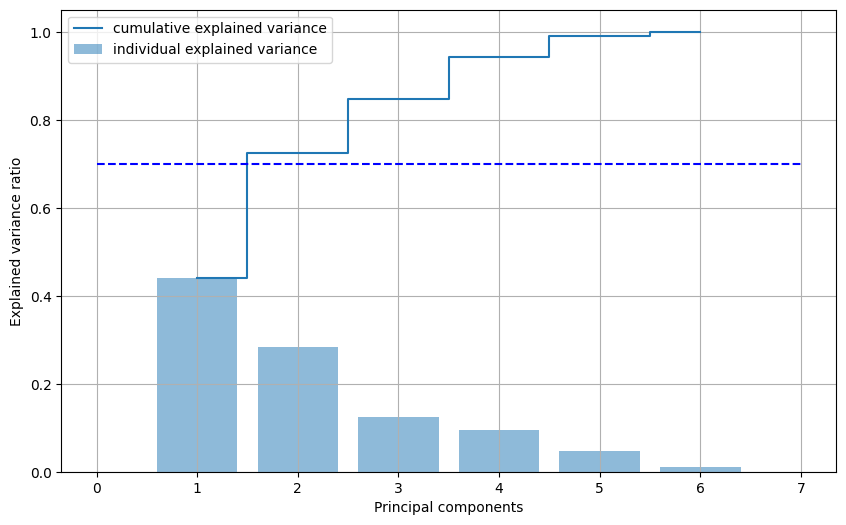

Number of components needed to explain 70% of variance: 2
Applying elbow method to determine optimal number of clusters...


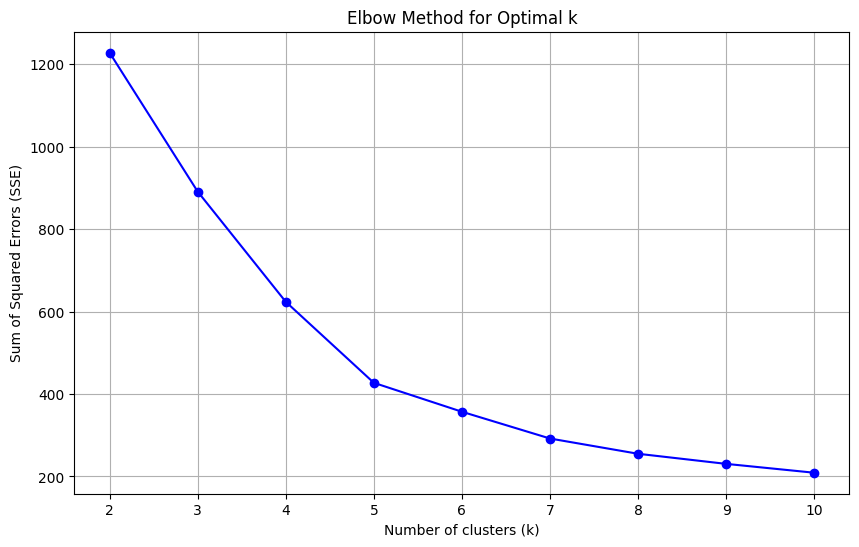

Applying silhouette analysis to determine optimal number of clusters...


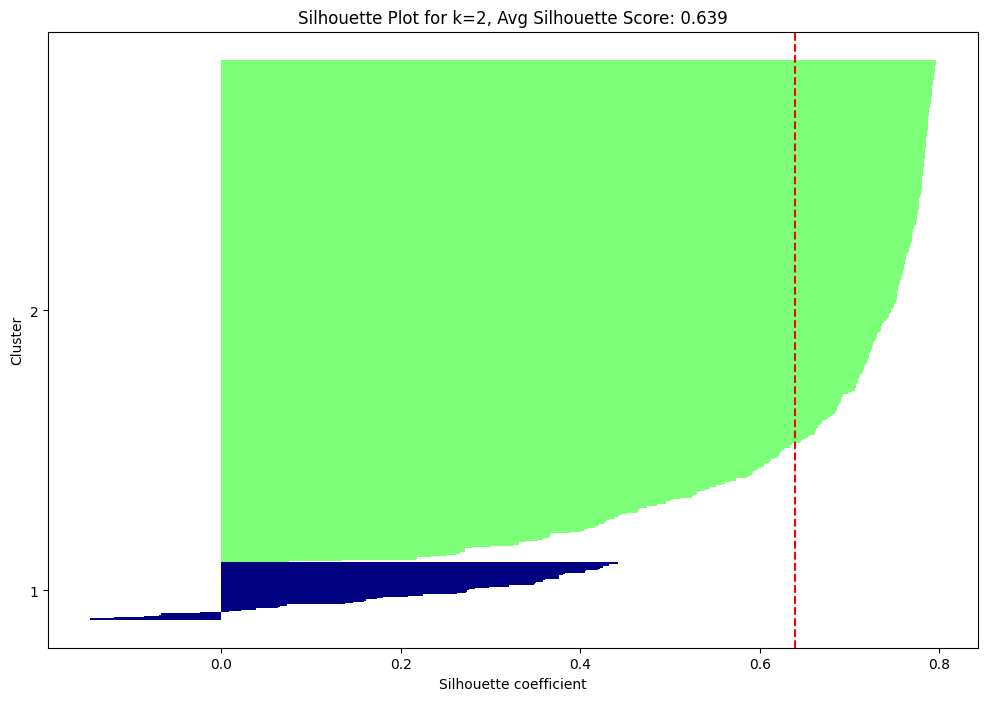

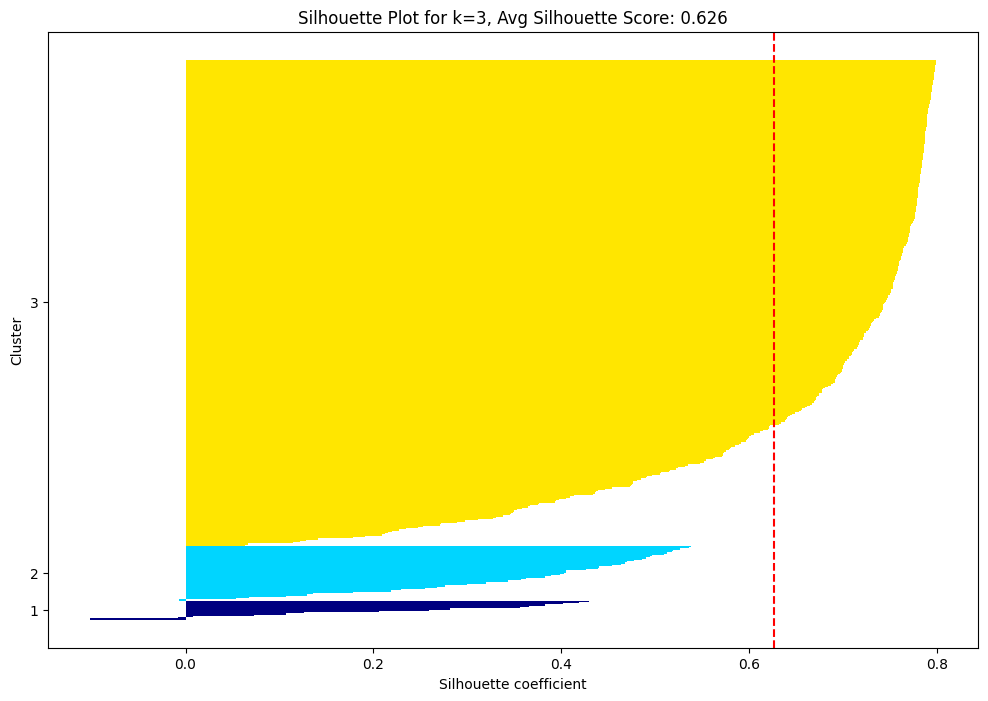

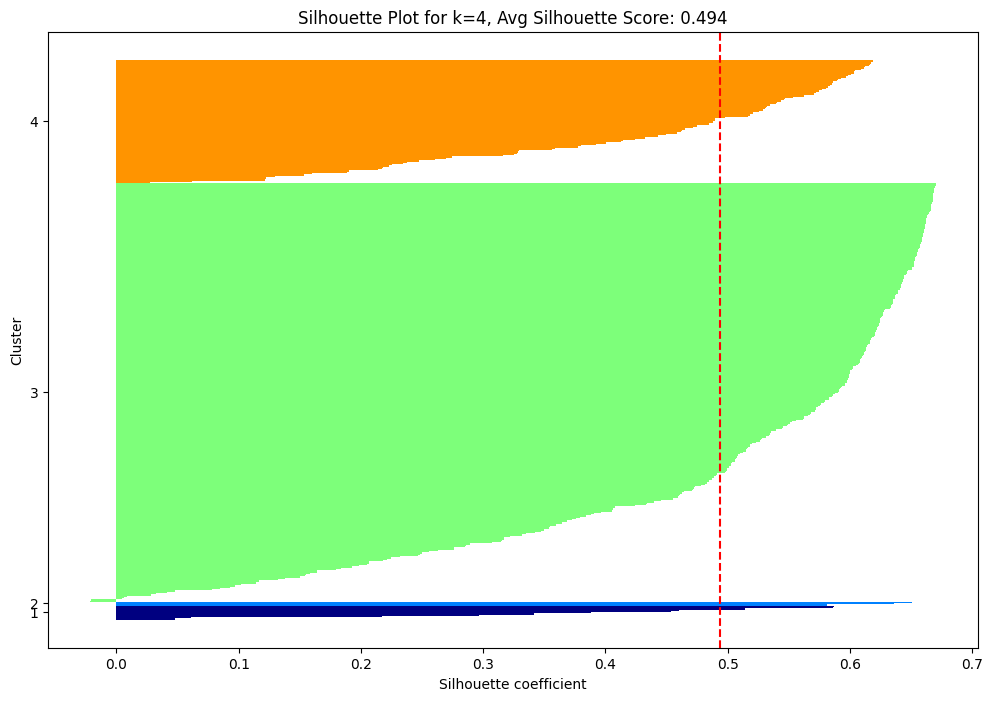

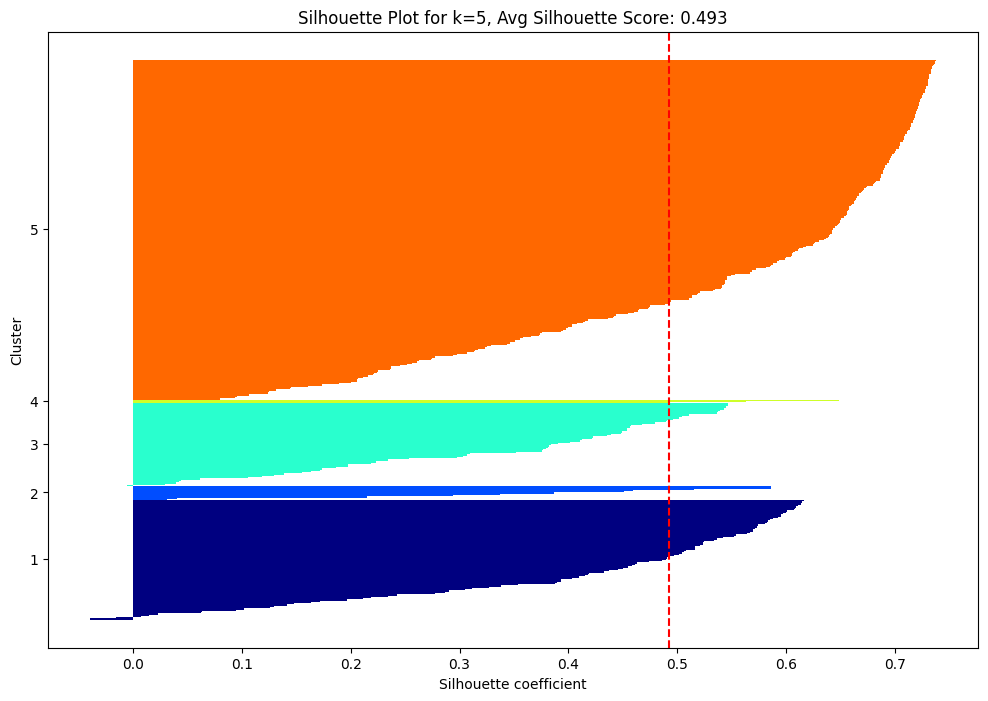

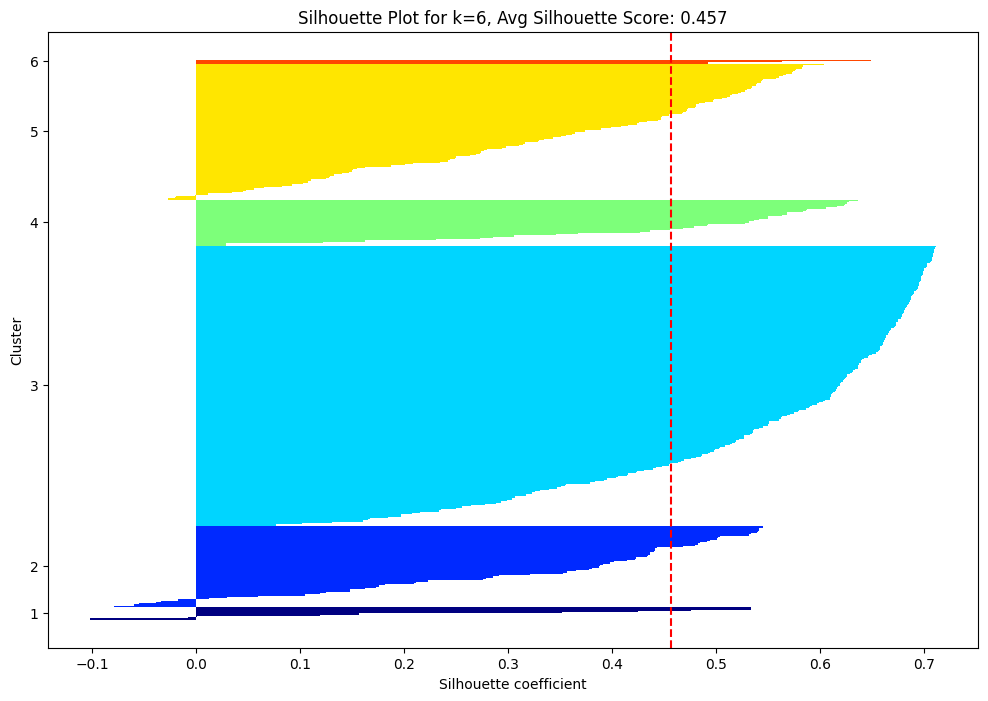

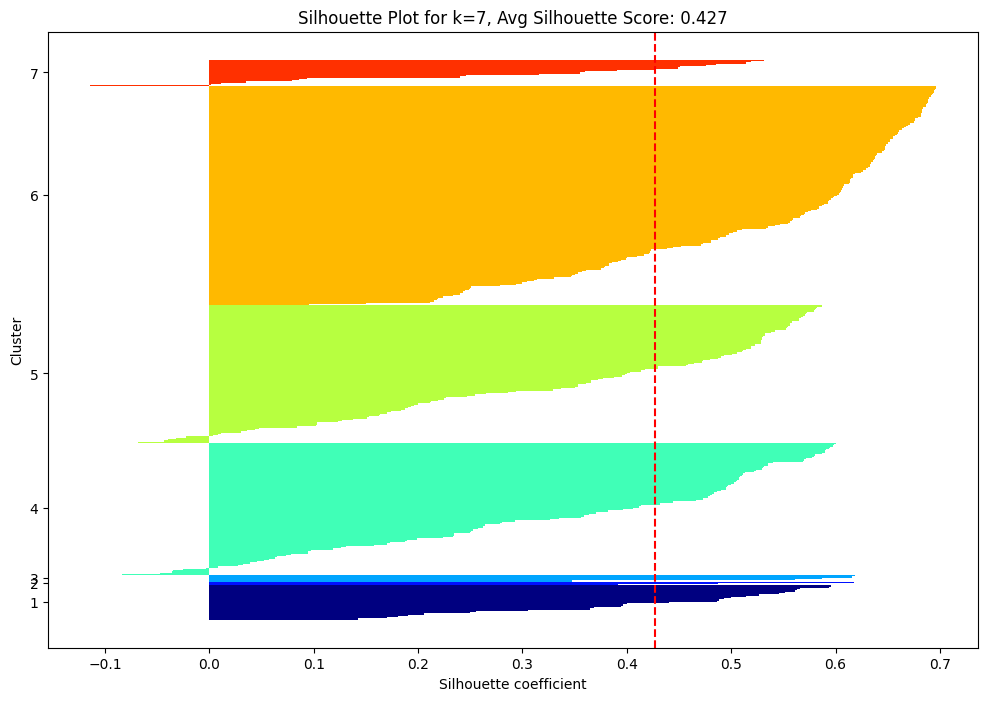

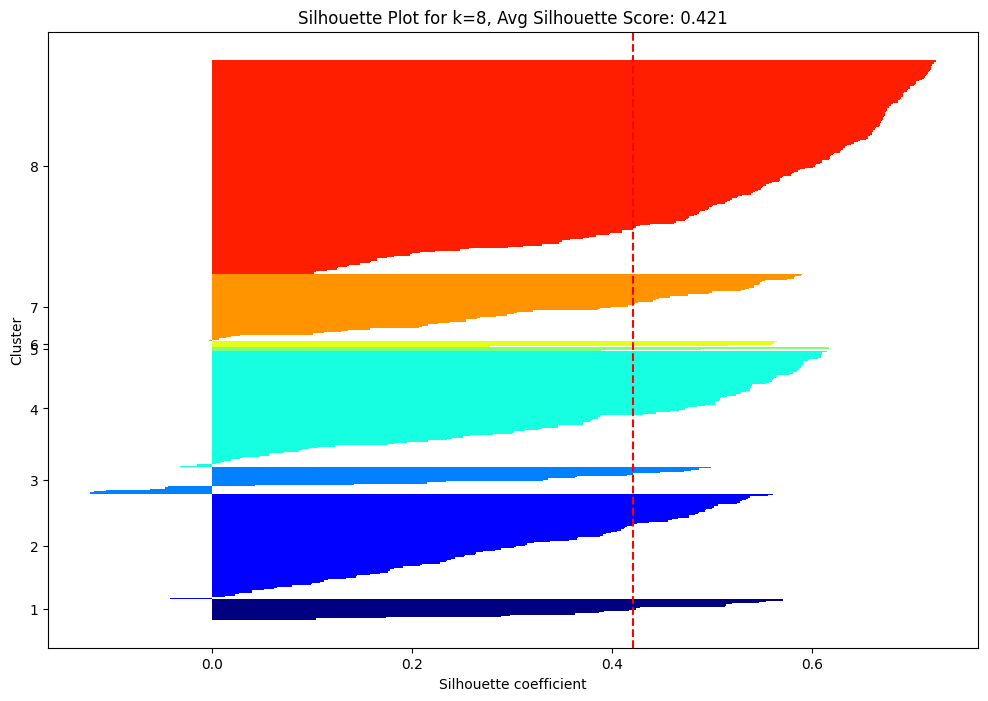

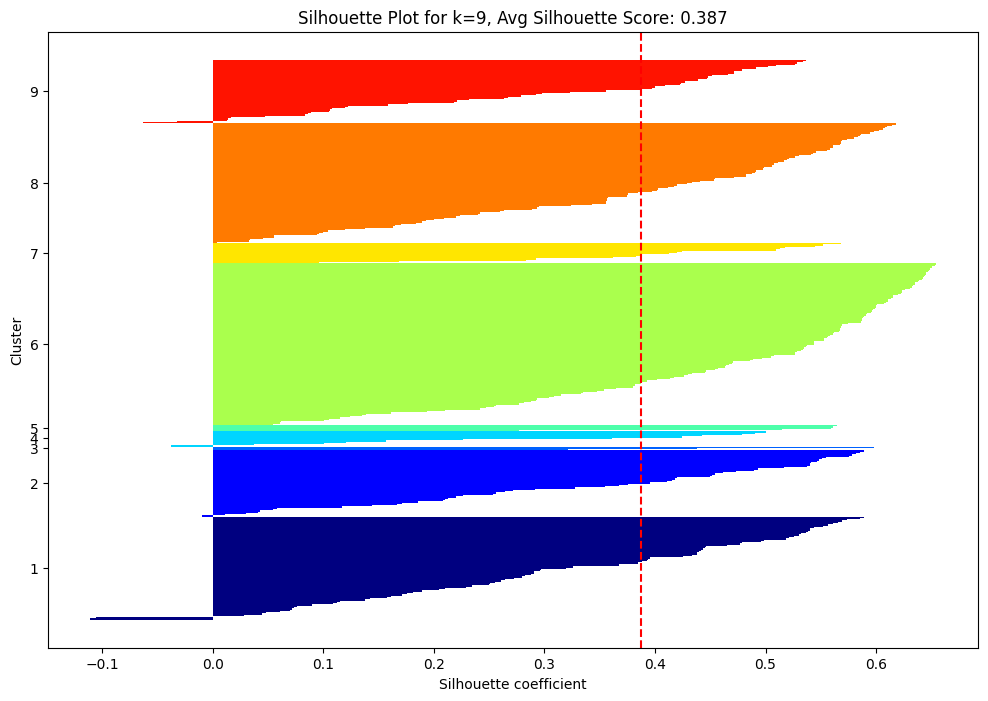

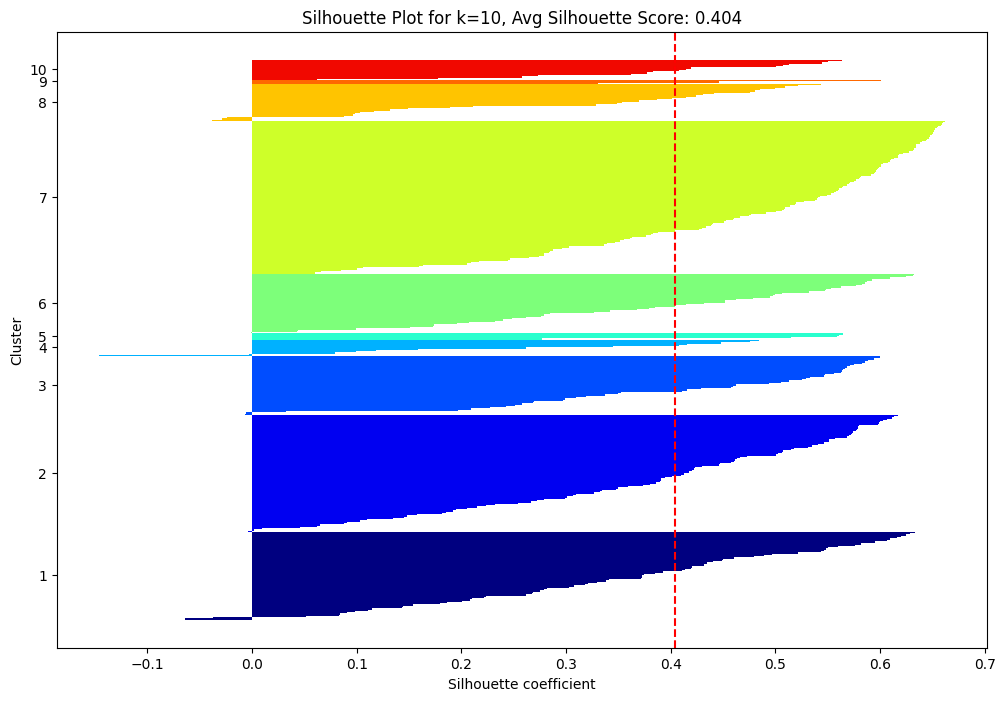

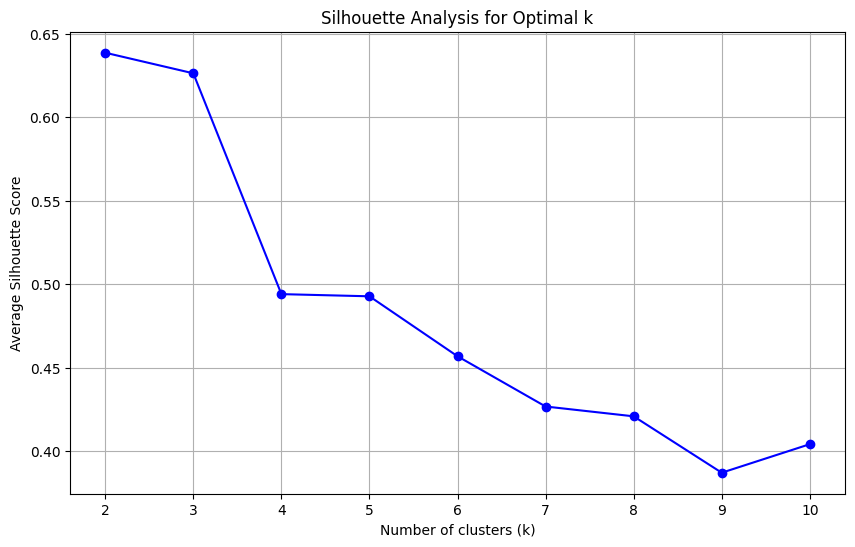

Selected optimal number of clusters: 3

Run 1/10
Iteration 2, centroid shift: 1.798562541691199
Iteration 3, centroid shift: 1.64397298363063
Iteration 4, centroid shift: 1.5379851647361271
Iteration 5, centroid shift: 1.2313441377193326
Iteration 6, centroid shift: 0.8114657728470482
Iteration 7, centroid shift: 0.51616576792034
Iteration 8, centroid shift: 0.3553215319074596
Iteration 9, centroid shift: 0.4585531578810977
Iteration 10, centroid shift: 0.5496964098079121
Iteration 11, centroid shift: 0.5336675307556497
Iteration 12, centroid shift: 0.5762901510113364
Iteration 13, centroid shift: 0.6137581936238123
Iteration 14, centroid shift: 0.6202716640551336
Iteration 15, centroid shift: 0.49308378633061
Iteration 16, centroid shift: 0.607367788603913
Iteration 17, centroid shift: 0.7068241023293154
Iteration 18, centroid shift: 0.7780322485882464
Iteration 19, centroid shift: 0.4939787921413043
Iteration 20, centroid shift: 0.0
Converged after 20 iterations
New best SSE: 902.517

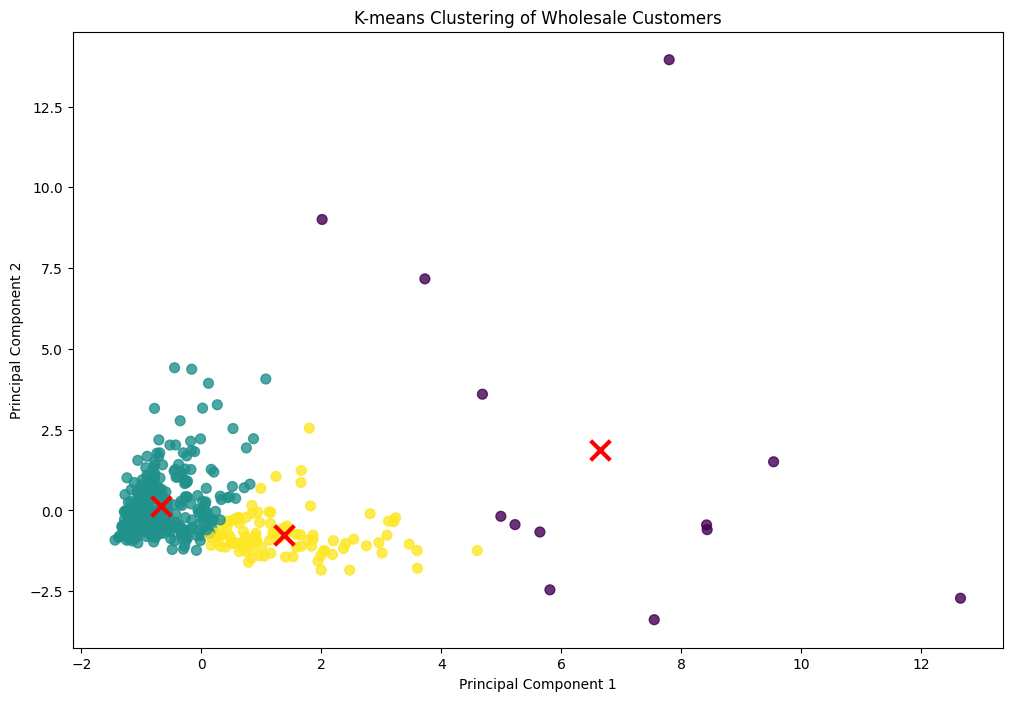

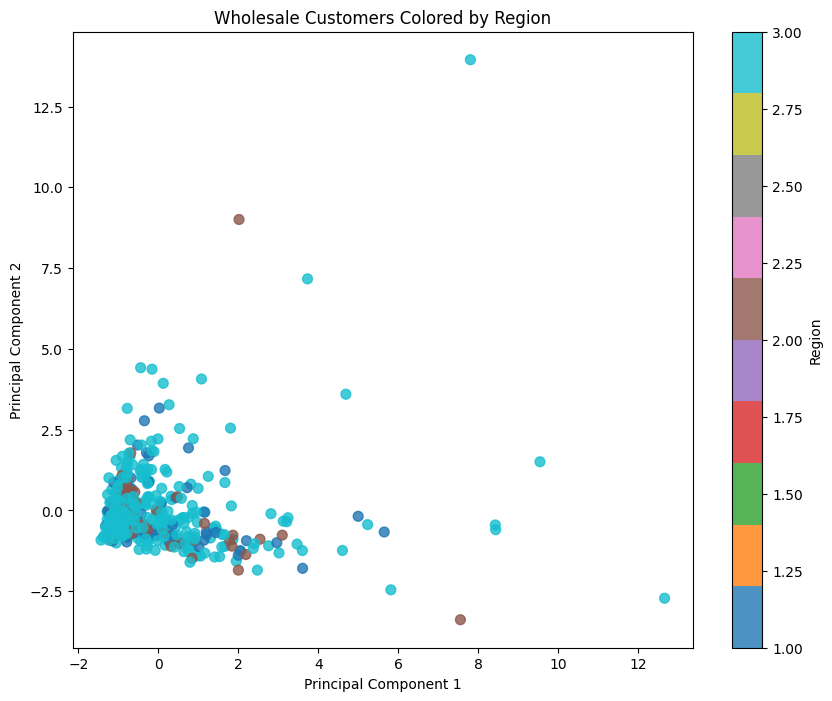

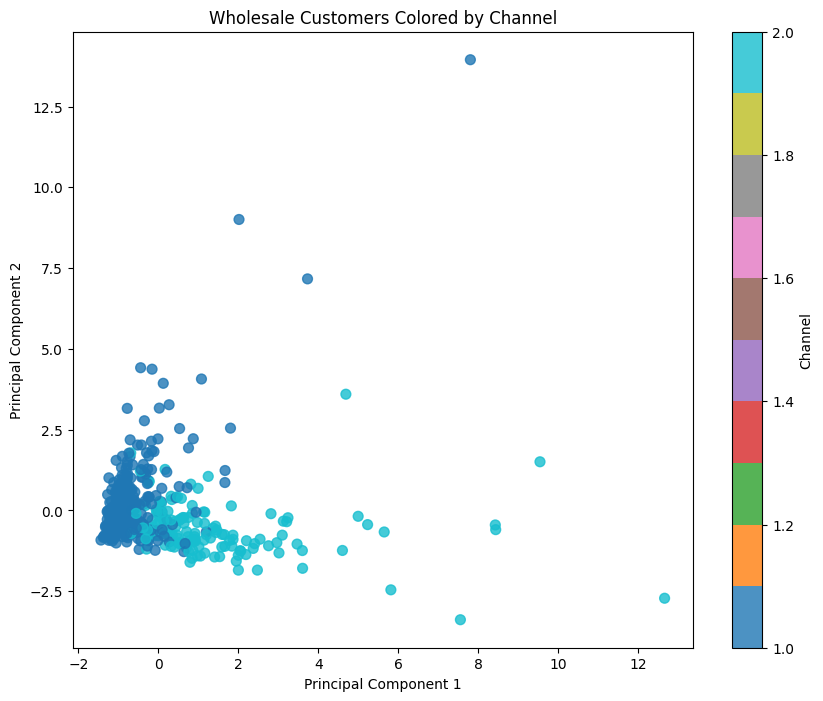

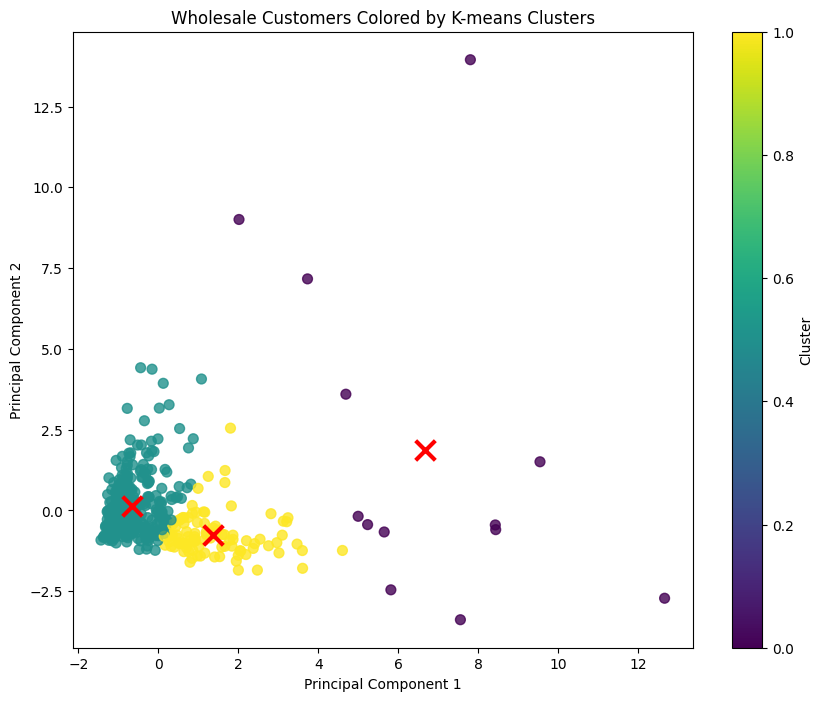

Comparison of K-means clusters with known groups:

Channel distribution within clusters:
col_0     0    1   2
Channel             
1         3  285  10
2        10   44  88

Region distribution within clusters:
col_0   0    1   2
Region            
1       2   59  16
2       2   33  12
3       9  237  70
Summary statistics for each cluster:
                Fresh                                 Milk           \
                 mean   median           std          mean   median   
Cluster                                                               
0        27972.230769  22925.0  28761.263023  34152.076923  29627.0   
1        13207.197568   9670.0  12217.656718   3254.841945   2380.0   
2         5829.836735   4047.0   6263.862771  10566.704082   9721.0   

                            Grocery                               Frozen  \
                  std          mean   median           std          mean   
Cluster                                                                    
0 

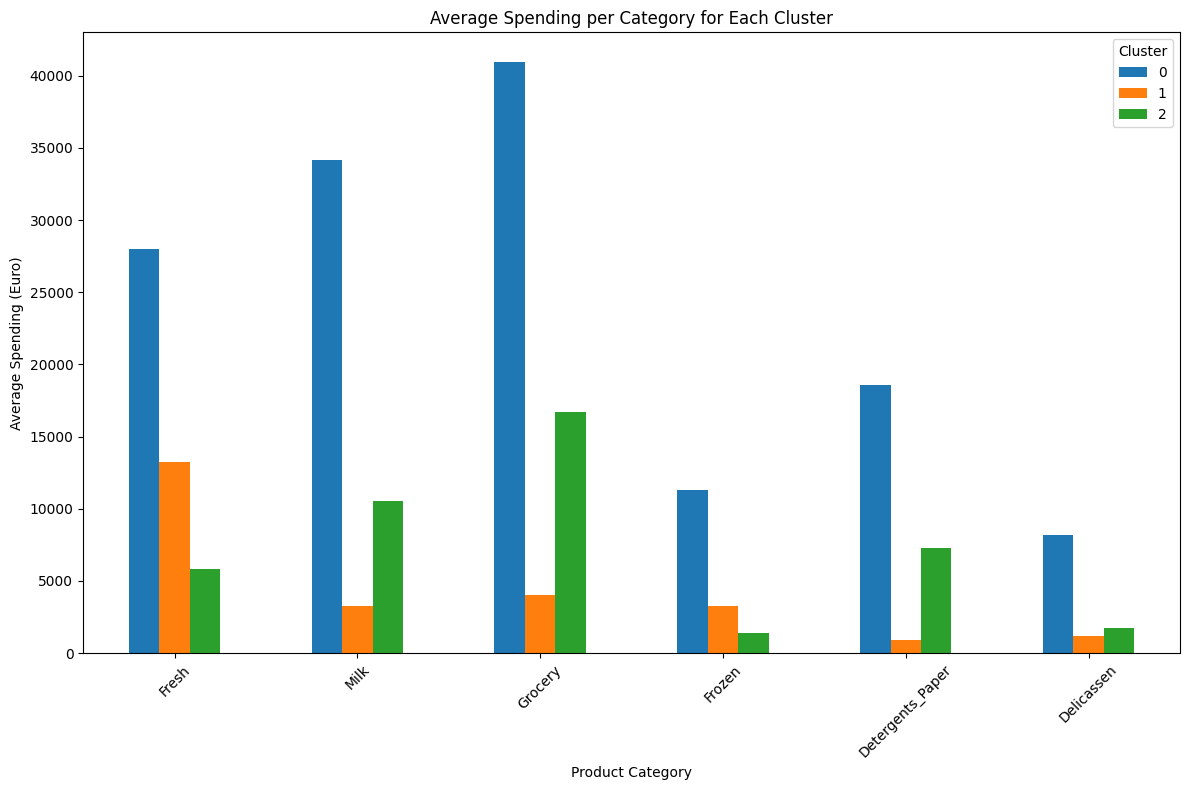


Channel distribution within clusters (%):
Cluster          0         1          2
Channel                                
1        23.076923  86.62614  10.204082
2        76.923077  13.37386  89.795918

Region distribution within clusters (%):
Cluster          0          1          2
Region                                  
1        15.384615  17.933131  16.326531
2        15.384615  10.030395  12.244898
3        69.230769  72.036474  71.428571

Insights for wholesalers:
1. Cluster Profiles:

Cluster 0:
- Top spending categories: Grocery, Milk
- Dominant channel: 2 (76.9%)
- Dominant region: 3 (69.2%)

Cluster 1:
- Top spending categories: Fresh, Grocery
- Dominant channel: 1 (86.6%)
- Dominant region: 3 (72.0%)

Cluster 2:
- Top spending categories: Grocery, Milk
- Dominant channel: 2 (89.8%)
- Dominant region: 3 (71.4%)

Research on other clustering methods:

Advantages of DBSCAN:
1. Does not require specifying the number of clusters in advance
2. Can find arbitrarily shaped cluster

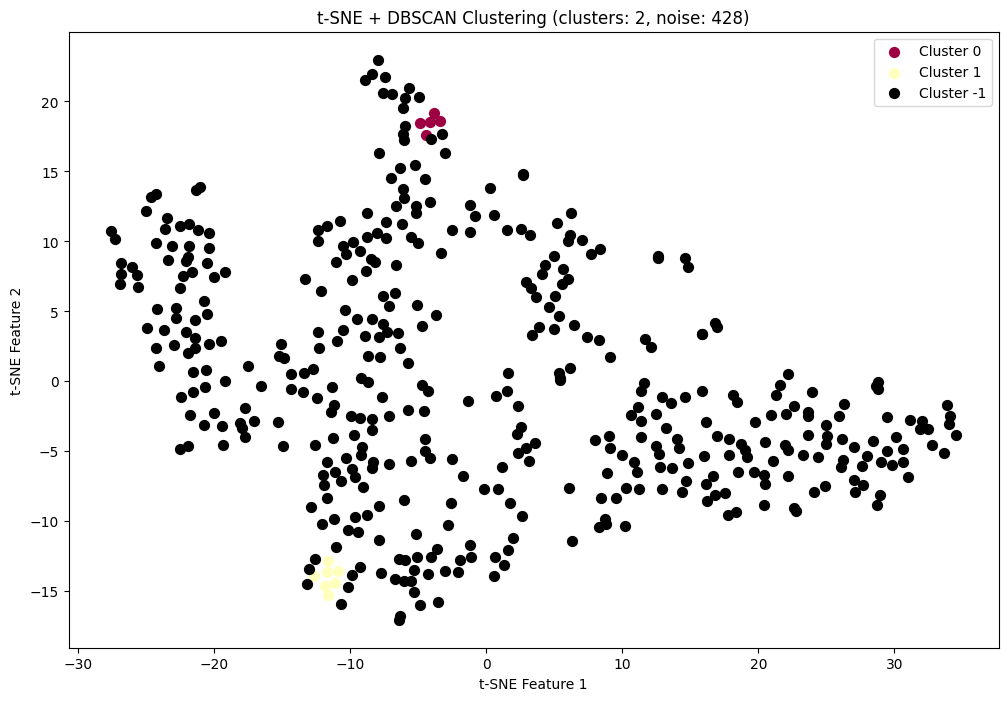

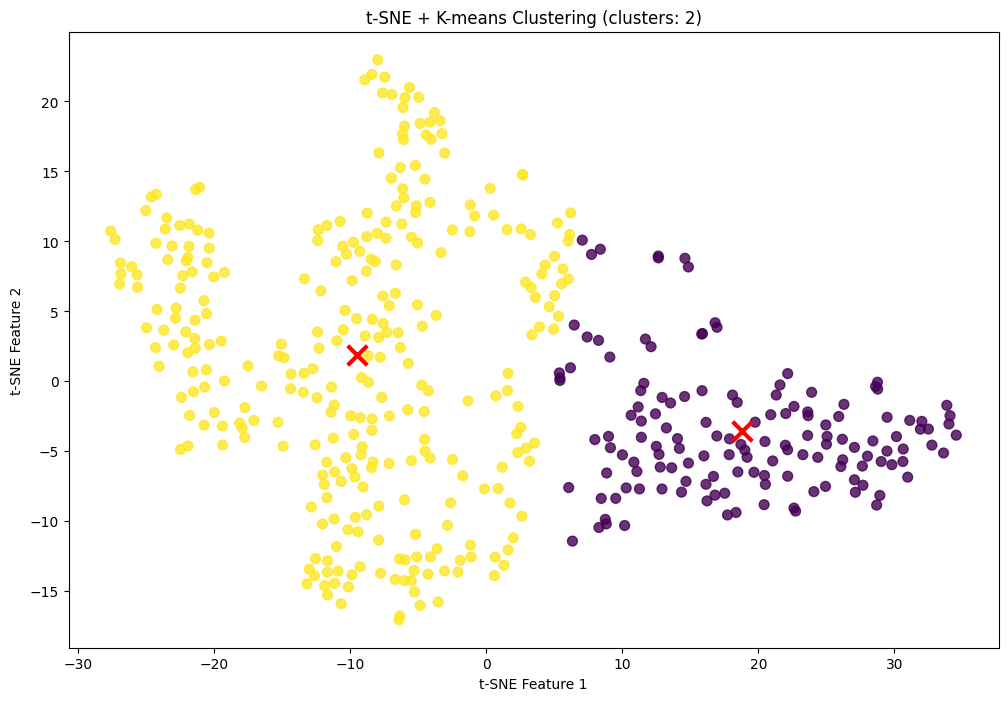

Adjusted Rand Index between DBSCAN and K-means: 0.000

Channel distribution within DBSCAN clusters (%):
DBSCAN_Cluster      0      1
Channel                     
1               100.0  100.0

Region distribution within DBSCAN clusters (%):
DBSCAN_Cluster      0          1
Region                          
1                 0.0  14.285714
2                 0.0  28.571429
3               100.0  57.142857

Summary statistics for each DBSCAN cluster:
                       Fresh             Milk        Grocery          \
                        mean   median    mean median    mean  median   
DBSCAN_Cluster                                                         
0               41446.600000  42312.0  1421.2  926.0  2167.6  2609.0   
1                 492.857143    542.0   880.0  879.0  1474.0  1664.0   

                     Frozen         Detergents_Paper         Delicassen         
                       mean  median             mean median        mean median  
DBSCAN_Cluster             

In [6]:
# Wholesale customers data analysis
def analyze_wholesale_data():
    # Load the data
    data = pd.read_csv('Wholesale customers data.csv')
    
    # Exclude 'Region' and 'Channel' for clustering
    features = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
    X = data[features].values
    
    # Standardize the data
    X_std = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    
    # PCA for dimensionality reduction
    pca = PCA(n_components=None)
    pca.fit(X_std)
    
    # Plot variance explained
    var_exp = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(var_exp)
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(features) + 1), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(1, len(features) + 1), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.hlines(0.7, 0, len(features) + 1, "blue", linestyles='dashed')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
    # Determine optimal number of components based on variance explained
    n_components = np.argmax(cum_var_exp >= 0.7) + 1
    print(f"Number of components needed to explain 70% of variance: {n_components}")
    
    # Reduce dimensions
    pca = PCA(n_components=2)  
    X_pca = pca.fit_transform(X_std)

    # Determine optimal number of clusters - Problem 10
    def determine_optimal_clusters(X_pca, k_range=range(2, 11)):
        # Use elbow method
        print("Applying elbow method to determine optimal number of clusters...")
        sse_values = elbow_method(X_pca, k_range)
        
        # Use silhouette analysis
        print("Applying silhouette analysis to determine optimal number of clusters...")
        silhouette_avgs = plot_silhouette(X_pca, k_range)
        
        # Here we could choose the optimal k based on the elbow method and silhouette analysis
        # let's select k=3 
        optimal_k = 3
        
        print(f"Selected optimal number of clusters: {optimal_k}")
        return optimal_k
    
    # Apply K-means with optimal k
    optimal_k = determine_optimal_clusters(X_pca)
    kmeans = ScratchKMeans(n_clusters=optimal_k, n_init=10, max_iter=300, tol=1e-4, verbose=True)
    kmeans.fit(X_pca)
    
    # Plot clusters
    plt.figure(figsize=(12, 8))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis', s=50, alpha=0.8)
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
                c='red', marker='x', s=200, linewidths=3)
    plt.title('K-means Clustering of Wholesale Customers')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()
    
    # Problem 11: Compare with known groups
    # Visualize clusters with known groups (Region and Channel)
    def visualize_with_known_groups(X_pca, data, kmeans):
        # Visualization with Region
        plt.figure(figsize=(10, 8))
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data['Region'], cmap='tab10', s=50, alpha=0.8)
        plt.title('Wholesale Customers Colored by Region')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.colorbar(label='Region')
        plt.show()
        
        # Visualization with Channel
        plt.figure(figsize=(10, 8))
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data['Channel'], cmap='tab10', s=50, alpha=0.8)
        plt.title('Wholesale Customers Colored by Channel')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.colorbar(label='Channel')
        plt.show()
        
        # Visualization with K-means clusters
        plt.figure(figsize=(10, 8))
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis', s=50, alpha=0.8)
        plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
                    c='red', marker='x', s=200, linewidths=3)
        plt.title('Wholesale Customers Colored by K-means Clusters')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.colorbar(label='Cluster')
        plt.show()
        
        # Compare clusters with known groups
        print("Comparison of K-means clusters with known groups:")
        
        # Analyze channel distribution within clusters
        channel_cluster_counts = pd.crosstab(data['Channel'], kmeans.labels_)
        print("\nChannel distribution within clusters:")
        print(channel_cluster_counts)
        
        # Analyze region distribution within clusters
        region_cluster_counts = pd.crosstab(data['Region'], kmeans.labels_)
        print("\nRegion distribution within clusters:")
        print(region_cluster_counts)
    
    visualize_with_known_groups(X_pca, data, kmeans)
    
    # Problem 12: Find useful information for wholesalers
    def analyze_clusters(X, data, kmeans_labels):
        # Create a DataFrame with original data and cluster labels
        cluster_data = data.copy()
        cluster_data['Cluster'] = kmeans_labels
        
        # Calculate summary statistics for each cluster
        cluster_stats = cluster_data.groupby('Cluster').agg({
            'Fresh': ['mean', 'median', 'std'],
            'Milk': ['mean', 'median', 'std'],
            'Grocery': ['mean', 'median', 'std'],
            'Frozen': ['mean', 'median', 'std'],
            'Detergents_Paper': ['mean', 'median', 'std'],
            'Delicassen': ['mean', 'median', 'std']
        })
        
        print("Summary statistics for each cluster:")
        print(cluster_stats)
        
        # Calculate average spending per category for each cluster
        avg_spending = cluster_data.groupby('Cluster')[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']].mean()
        
        # Visualize the average spending per category for each cluster
        avg_spending.T.plot(kind='bar', figsize=(12, 8))
        plt.title('Average Spending per Category for Each Cluster')
        plt.ylabel('Average Spending (Euro)')
        plt.xlabel('Product Category')
        plt.legend(title='Cluster')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        # Analyze Channel distribution within clusters
        channel_cluster = pd.crosstab(cluster_data['Channel'], cluster_data['Cluster'], normalize='columns') * 100
        print("\nChannel distribution within clusters (%):")
        print(channel_cluster)
        
        # Analyze Region distribution within clusters
        region_cluster = pd.crosstab(cluster_data['Region'], cluster_data['Cluster'], normalize='columns') * 100
        print("\nRegion distribution within clusters (%):")
        print(region_cluster)
        
        # Write insights
        print("\nInsights for wholesalers:")
        print("1. Cluster Profiles:")
        for cluster in range(optimal_k):
            print(f"\nCluster {cluster}:")
            cluster_df = cluster_data[cluster_data['Cluster'] == cluster]
            # Get the top 2 categories for this cluster
            avg_cluster = cluster_df[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']].mean()
            top_categories = avg_cluster.nlargest(2).index.tolist()
            print(f"- Top spending categories: {', '.join(top_categories)}")
            
            # Channel distribution
            channel_dist = cluster_df['Channel'].value_counts(normalize=True) * 100
            dominant_channel = channel_dist.idxmax()
            print(f"- Dominant channel: {dominant_channel} ({channel_dist.max():.1f}%)")
            
            # Region distribution
            region_dist = cluster_df['Region'].value_counts(normalize=True) * 100
            dominant_region = region_dist.idxmax()
            print(f"- Dominant region: {dominant_region} ({region_dist.max():.1f}%)")
    
    analyze_clusters(X, data, kmeans.labels_)
    
    # Problem 13: Research on other clustering methods
    def research_other_methods():
        print("\nResearch on other clustering methods:")
        
        print("\nAdvantages of DBSCAN:")
        print("1. Does not require specifying the number of clusters in advance")
        print("2. Can find arbitrarily shaped clusters")
        print("3. Robust to outliers")
        print("4. Only requires two parameters: epsilon (neighborhood radius) and minPts (minimum points in a cluster)")
        
        print("\nDisadvantages of DBSCAN:")
        print("1. Struggles with clusters of varying densities")
        print("2. Sensitive to parameter selection")
        print("3. Can be computationally expensive for large datasets")
        print("4. Does not work well with high-dimensional data")
        
        print("\nAdvantages of t-SNE:")
        print("1. Excellent for visualizing high-dimensional data in 2D or 3D")
        print("2. Preserves local structure - similar data points stay close together")
        print("3. Can reveal clusters or patterns that PCA might miss")
        print("4. Works well with nonlinear relationships")
        
        print("\nDisadvantages of t-SNE:")
        print("1. Computationally intensive for large datasets")
        print("2. Sensitive to hyperparameters, especially perplexity")
        print("3. Global structure not always preserved")
        print("4. Different runs can produce different results")
        
        print("\nAdvantages of LLE (Locally Linear Embedding):")
        print("1. Preserves local relationships between points")
        print("2. Can handle nonlinear data")
        print("3. No need for distance metrics")
        print("4. Computationally efficient for certain types of data")
        
        print("\nDisadvantages of LLE:")
        print("1. Sensitive to the number of neighbors parameter")
        print("2. May not work well with noisy data")
        print("3. Cannot handle data with holes or disconnected manifolds")
        print("4. Not suitable for very high-dimensional data or large datasets")
    
    research_other_methods()
    
    # Problem 14: Using t-SNE and DBSCAN
    def compare_tsne_dbscan(X_std, data):
        # Apply t-SNE for dimensionality reduction
        tsne = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=2000)
        X_tsne = tsne.fit_transform(X_std)
        
        # Apply DBSCAN
        dbscan = DBSCAN(eps=1.0, min_samples=5)
        dbscan_labels = dbscan.fit_predict(X_tsne)
        
        # Count the number of clusters (excluding noise points which are labeled as -1)
        n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
        n_noise = list(dbscan_labels).count(-1)
        
        print(f"Number of clusters found by DBSCAN: {n_clusters}")
        print(f"Number of noise points: {n_noise}")
        
        # Visualize t-SNE with DBSCAN clusters
        plt.figure(figsize=(12, 8))
        unique_labels = set(dbscan_labels)
        colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
        
        for k, col in zip(unique_labels, colors):
            if k == -1:
                # Black used for noise points
                col = [0, 0, 0, 1]
            
            class_member_mask = (dbscan_labels == k)
            xy = X_tsne[class_member_mask]
            plt.scatter(xy[:, 0], xy[:, 1], s=50, c=[col], label=f'Cluster {k}')
            
        plt.title(f't-SNE + DBSCAN Clustering (clusters: {n_clusters}, noise: {n_noise})')
        plt.xlabel('t-SNE Feature 1')
        plt.ylabel('t-SNE Feature 2')
        plt.legend()
        plt.show()
        
        # Compare with PCA + K-means results
        # Apply K-means with the same number of clusters found by DBSCAN
        if n_clusters > 1:
            kmeans = ScratchKMeans(n_clusters=n_clusters, n_init=10, max_iter=300, tol=1e-4)
            kmeans.fit(X_tsne)
            
            # Visualize t-SNE with K-means clusters
            plt.figure(figsize=(12, 8))
            plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans.labels_, cmap='viridis', s=50, alpha=0.8)
            plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                        c='red', marker='x', s=200, linewidths=3)
            plt.title(f't-SNE + K-means Clustering (clusters: {n_clusters})')
            plt.xlabel('t-SNE Feature 1')
            plt.ylabel('t-SNE Feature 2')
            plt.show()
            
            # Calculate adjusted Rand index between DBSCAN and K-means labels
            from sklearn.metrics.cluster import adjusted_rand_score
            ari = adjusted_rand_score(dbscan_labels[dbscan_labels != -1], 
                                    kmeans.labels_[dbscan_labels != -1])
            print(f"Adjusted Rand Index between DBSCAN and K-means: {ari:.3f}")
        
        # Compare channel and region distribution within DBSCAN clusters
        cluster_data = data.copy()
        cluster_data['DBSCAN_Cluster'] = dbscan_labels
        
        # Only analyze non-noise points
        valid_clusters = cluster_data[cluster_data['DBSCAN_Cluster'] != -1]
        
        if len(valid_clusters) > 0 and n_clusters > 1:
            # Channel distribution
            channel_cluster = pd.crosstab(valid_clusters['Channel'], valid_clusters['DBSCAN_Cluster'], normalize='columns') * 100
            print("\nChannel distribution within DBSCAN clusters (%):")
            print(channel_cluster)
            
            # Region distribution
            region_cluster = pd.crosstab(valid_clusters['Region'], valid_clusters['DBSCAN_Cluster'], normalize='columns') * 100
            print("\nRegion distribution within DBSCAN clusters (%):")
            print(region_cluster)
            
            # Calculate summary statistics for each DBSCAN cluster
            cluster_stats = valid_clusters.groupby('DBSCAN_Cluster').agg({
                'Fresh': ['mean', 'median'],
                'Milk': ['mean', 'median'],
                'Grocery': ['mean', 'median'],
                'Frozen': ['mean', 'median'],
                'Detergents_Paper': ['mean', 'median'],
                'Delicassen': ['mean', 'median']
            })
            
            print("\nSummary statistics for each DBSCAN cluster:")
            print(cluster_stats)
    
    compare_tsne_dbscan(X_std, data)
    
    return kmeans

if __name__ == "__main__":
    # Test the implementation with sample data
    print("Testing K-means implementation with sample data...")
    test_kmeans()
    
    # Analyze wholesale customers data
    print("\nAnalyzing wholesale customers data...")
    analyze_wholesale_data()

